In [8]:
from facenet_pytorch import MTCNN
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from tqdm import tqdm 
from PIL import Image 
import cv2 
import os 
import time 
import numpy as np 
from typing import Dict, Union 
from torchinfo import summary 
from glob import glob 
import matplotlib.pyplot as plt
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score

In [33]:
resize = 160
THRESHOLD = 0.58
device = "cuda:0" if torch.cuda.is_available() else "cpu"

def load_model(is_lr=False):
    model = InceptionResnetV1(pretrained="vggface2")
    if is_lr:
        model.load_state_dict(torch.load("facenet1.pth", map_location={"cuda:0", "cpu"}))
    model.eval()
    model.to(device)
    mtcnn = MTCNN()
    return model, mtcnn 
    
transform = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*2-1)
])
    
def detect(img_tensor, model):
    output = model(img_tensor)
    output = output.detach().cpu().numpy() # (512, )
    return output 

def show_img(img1, img2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 12))
    ax = axes.ravel()
    ax[0].imshow(img1.permute(1, 2, 0))
    ax[1].imshow(img2.permute(1, 2, 0))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
def inference(img1_path: str, img2_path: str, is_lr=False) -> Dict[str, Union[float, str]]:
    with torch.no_grad():
        start = time.time()
        model, mtcnn = load_model(is_lr)
        # 画像の表示
        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")
        # 画像から顔部分の摘出
        img1 = mtcnn(img1)
        img2 = mtcnn(img2)
        show_img(img1, img2)
        # 前処理
        img1_tensor = img1.unsqueeze(0)
        img2_tensor = img2.unsqueeze(0)
        # 推論実行
        out1 = detect(img1_tensor, model)
        out2 = detect(img2_tensor, model)
        # コサイン類似度の算出
        sim = cosine_similarity(out1, out2)
        usr = (sim > THRESHOLD).any()
        predict = "同人物" if usr else "別人物"
        elapsed = time.time() - start 
        results = {
            "predict": predict, 
            "score": sim[0][0], 
            "elapsed": elapsed
        }
        return results 

In [46]:
def sample():
    sample_imgs = glob("./data/*.jpg")
    a = np.random.randint(0, len(sample_imgs), 2)
    results = inference(sample_imgs[a[0]], sample_imgs[a[1]])
    return results 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


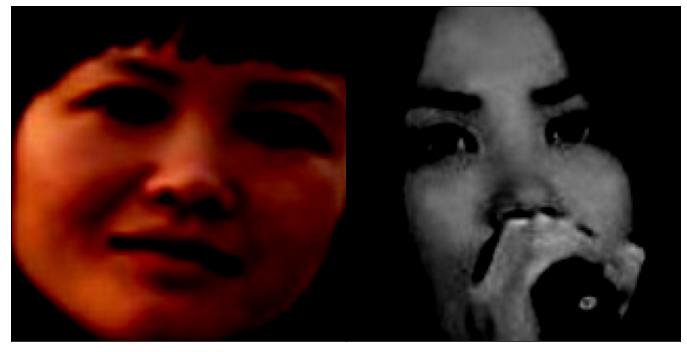

{'predict': '別人物', 'score': 0.49298942, 'elapsed': 1.0392346382141113}

In [47]:
sample()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


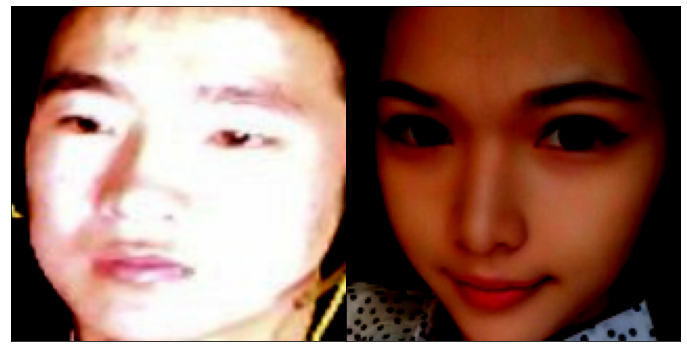

{'predict': '別人物', 'score': 0.20740737, 'elapsed': 1.336848258972168}

In [48]:
sample()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


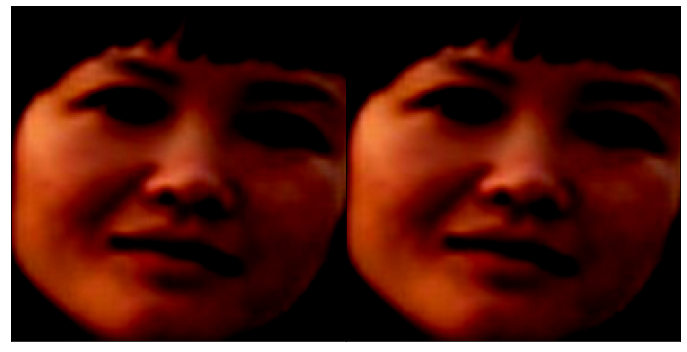

{'predict': '同人物', 'score': 1.0000001, 'elapsed': 1.3345861434936523}

In [52]:
sample()